### Generating some data

Lets generate a classification dataset that is not easily linearly separable. Our favorite example is the spiral dataset, which can be generated as follows:

In [1]:

# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

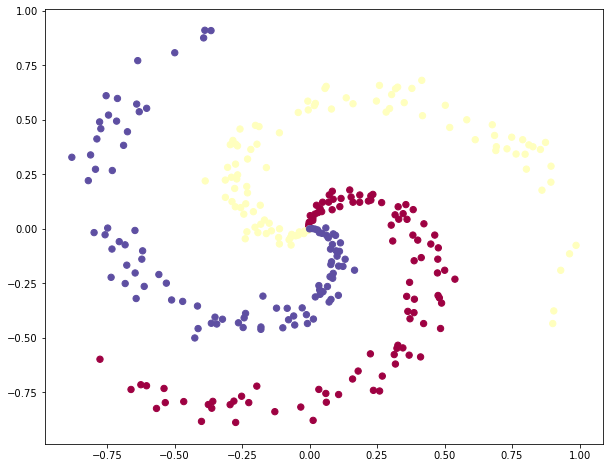

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
X.shape, y.shape

((300, 2), (300,))

In [4]:
# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

The toy spiral data consists of three classes (blue, red, yellow) that are not linearly separable.

Normally we would want to preprocess the dataset so that each feature has zero mean and unit standard deviation, but in this case the features are already in a nice range from -1 to 1, so we skip this step.

### Training a Softmax Linear Classifier

#### Initialize the parameters

Lets first train a Softmax classifier on this classification dataset. The Softmax classifier has a linear score function and uses the cross-entropy loss. The parameters of the linear classifier consist of a weight matrix W and a bias vector b for each class. Lets first initialize these parameters to be random numbers:

In [5]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))
W, b

(array([[-0.01200694,  0.00016175, -0.02588581],
        [ 0.00304555, -0.00248687,  0.01773349]]), array([[0., 0., 0.]]))

Recall that we **D** = 2 is the **dimensionality** and **K** = 3 is the **number of classes**.

#### Compute the class scores

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication:

In [6]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b
scores.shape

(300, 3)

In this example we have 300 2-D points, so after this multiplication the array scores will have size [300 x 3], where each row gives the class scores corresponding to the 3 classes (blue, red, yellow).

<img src='images/25_.JPG'>

Given the array of scores we’ve computed above, we can compute the loss. First, the way to obtain the probabilities is straight forward:

In [7]:
num_examples = X.shape[0]
# get unnormalized probabilities
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

We now have an array probs of size [300 x 3], where each row now contains the class probabilities. In particular, since we’ve normalized them every row now sums to one. We can now query for the log probabilities assigned to the correct classes in each example:

In [8]:
correct_logprobs = -np.log(probs[range(num_examples),y])
correct_logprobs[:5]

array([1.09861229, 1.09864343, 1.09867494, 1.09870545, 1.0987229 ])

The array correct_logprobs is a 1D array of just the probabilities assigned to the correct classes for each example. The full loss is then the average of these log probabilities and the regularization loss:

In [9]:
reg = 0.5

# compute the loss: average cross-entropy loss and regularization
data_loss = np.sum(correct_logprobs)/num_examples
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss
loss

1.0976866992047898

In this code, the regularization strength λ is stored inside the reg. The convenience factor of 0.5 multiplying the regularization will become clear in a second. Evaluating this in the beginning (with random parameters) might give us loss = 1.1, which is -np.log(1.0/3), since with small initial random weights all probabilities assigned to all classes are about one third. We now want to make the loss as low as possible, with loss = 0 as the absolute lower bound. But the lower the loss is, the higher are the probabilities assigned to the correct classes for all examples.

#### Computing the Analytic Gradient with Backpropagation

<img src='images/26_.JPG'>

<img src='images/27_.JPG'>


All of this boils down to the following code. Recall that probs stores the probabilities of all classes (as rows) for each example. To get the gradient on the scores, which we call dscores, we proceed as follows:

In [10]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples
dscores.shape

(300, 3)

Lastly, we had that scores = np.dot(X, W) + b, so armed with the gradient on scores (stored in dscores), we can now backpropagate into W and b:

In [11]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += reg*W # don't forget the regularization gradient

Where we see that we have backpropped through the matrix multiply operation, and also added the contribution from the regularization. Note that the regularization gradient has the very simple form reg*W since we used the constant 0.5 for its loss contribution (i.e. ddw(12λw2)=λw. This is a common convenience trick that simplifies the gradient expression

#### Performing a parameter update

Now that we’ve evaluated the gradient we know how every parameter influences the loss function. We will now perform a parameter update in the negative gradient direction to decrease the loss:

In [12]:
step_size = 0.001

In [13]:
# perform a parameter update
W += -step_size * dW
b += -step_size * db

#### Putting it all together: Training a Softmax Classifier

Putting all of this together, here is the full code for training a Softmax classifier with Gradient descent:

In [14]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

  # evaluate class scores, [N x K]
  scores = np.dot(X, W) + b

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W)
  loss = data_loss + reg_loss
  if i % 10 == 0:
    print ("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)

  dW += reg*W # regularization gradient

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.093868
iteration 10: loss 0.905735
iteration 20: loss 0.835767
iteration 30: loss 0.804008
iteration 40: loss 0.787531
iteration 50: loss 0.778203
iteration 60: loss 0.772598
iteration 70: loss 0.769085
iteration 80: loss 0.766813
iteration 90: loss 0.765308
iteration 100: loss 0.764293
iteration 110: loss 0.763598
iteration 120: loss 0.763117
iteration 130: loss 0.762780
iteration 140: loss 0.762543
iteration 150: loss 0.762374
iteration 160: loss 0.762255
iteration 170: loss 0.762169
iteration 180: loss 0.762107
iteration 190: loss 0.762062


In [15]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.52


This prints 52%. Not very good at all, but also not surprising given that the dataset is constructed so it is not linearly separable. We can also plot the learned decision boundaries:

<img src='images/28__.JPG'>



(-1.8881395842765305, 1.8918604157234729)

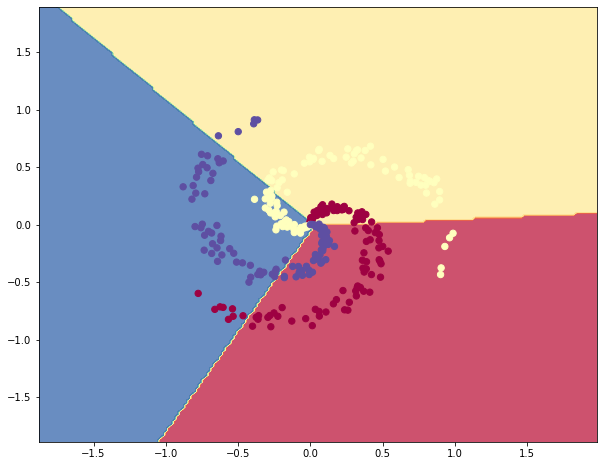

In [17]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

### Training a Neural Network

Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):

In [18]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

The forward pass to compute scores now changes form:



In [19]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

Notice that the only change from before is one extra line of code, where we first compute the hidden layer representation and then the scores based on this hidden layer. Crucially, we’ve also added a non-linearity, which in this case is simple ReLU that thresholds the activations on the hidden layer at zero.

Everything else remains the same. We compute the loss based on the scores exactly as before, and get the gradient for the scores dscores exactly as before. However, the way we backpropagate that gradient into the model parameters now changes form, of course. First lets backpropagate the second layer of the Neural Network. This looks identical to the code we had for the Softmax classifier, except we’re replacing X (the raw data), with the variable hidden_layer):

In [20]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

However, unlike before we are not yet done, because hidden_layer is itself a function of other parameters and the data! We need to continue backpropagation through this variable. Its gradient can be computed as

In [21]:
dhidden = np.dot(dscores, W2.T)

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since r=max(0,x), we have that dr/dx=1(x>0). Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but kills it if its input was less than zero during the forward pass. Hence, we can backpropagate the ReLU in place simply with:

In [22]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

And now we finally continue to the first layer weights and biases:

In [23]:
# finally into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

We’re done! We have the gradients dW,db,dW2,db2 and can perform the parameter update. Everything else remains unchanged. The full code looks very similar:

In [24]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):

  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2

  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

  # compute the loss: average cross-entropy loss and regularization
  correct_logprobs = -np.log(probs[range(num_examples),y])
  data_loss = np.sum(correct_logprobs)/num_examples
  reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
  loss = data_loss + reg_loss
  if i % 1000 == 0:
    print ("iteration %d: loss %f" % (i, loss))

  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples

  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)

  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W

  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098620
iteration 1000: loss 0.299537
iteration 2000: loss 0.258288
iteration 3000: loss 0.250960
iteration 4000: loss 0.249587
iteration 5000: loss 0.248730
iteration 6000: loss 0.248074
iteration 7000: loss 0.247836
iteration 8000: loss 0.247555
iteration 9000: loss 0.247286


In [25]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.99


Which prints 99%!. We can also visualize the decision boundaries:

<img src='images/29__.JPG'>

(-1.8881395842765305, 1.8918604157234729)

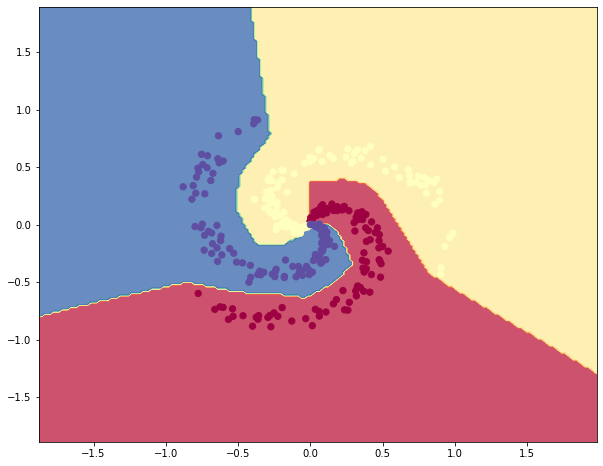

In [26]:

# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_net.png')

We’ve worked with a toy 2D dataset and trained both a linear network and a 2-layer Neural Network. We saw that the change from a linear classifier to a Neural Network involves very few changes in the code. The score function changes its form (1 line of code difference), and the backpropagation changes its form (we have to perform one more round of backprop through the hidden layer to the first layer of the network).

download the <a href ='https://cs.stanford.edu/people/karpathy/cs231nfiles/minimal_net.html'>  ipynb file </a>